<a href="https://colab.research.google.com/github/mambahuang/OpenCV_DL/blob/master/ResNet_train_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 121663 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3+git20210102-6ubuntu0.1_amd64.deb ...
Unpacking w3m (0.5.3+git20210102-6ubuntu0.1) ...
Setting up w3m (0.5.3+git20210102-6ubuntu0.1) ...
Processing triggers for man-db (2.10.2-1) ...
/content
/content/drive
/content
/
Access token retrieved correctly.


In [ ]:
from zipfile import ZipFile

with ZipFile('/content/drive/MyDrive/ResNet_dataset/Dataset_OpenCvDl_Hw2_Q5.zip', 'r') as zip_ref:
  zip_ref.extractall(path='/content')


### python lib import

In [ ]:
from sys import int_info
from time import sleep

import numpy as np
import glob
import matplotlib.pyplot as plt

import os
import cv2
import pickle
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset
# import torchvision.transforms as transforms
from torchvision import transforms
from torchvision.transforms import v2
import torchvision.models as models

import torchvision
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

from torchsummary import summary

import warnings
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

### Parameter

In [ ]:
# num_classes = 2
batch_size = 64
# learning_rate = 0.0001
# op = 'Adam'
# epochs = 40
weight_decay = 1e-4
# optimizers = {'SGD':torch.optim.SGD, 'Adam':torch.optim.Adam, 'RMSprop':torch.optim.RMSprop}

### DataSet

In [ ]:
DIR_TRAIN = "/content/Dataset_OpenCvDl_Hw2_Q5/dataset/training_dataset"
DIR_TEST = "/content/Dataset_OpenCvDl_Hw2_Q5/dataset/validation_dataset"
DIR_TRAIN_CAT = "/content/Dataset_OpenCvDl_Hw2_Q5/dataset/training_dataset/Cat"
DIR_TRAIN_DOG = "/content/Dataset_OpenCvDl_Hw2_Q5/dataset/training_dataset/Dog"
DIR_TEST_CAT = "/content/Dataset_OpenCvDl_Hw2_Q5/dataset/validation_dataset/Cat"
DIR_TEST_DOG = "/content/Dataset_OpenCvDl_Hw2_Q5/dataset/validation_dataset/Dog"
DIR_INFER = "/content/Dataset_OpenCvDl_Hw2_Q5/dataset/inference_dataset"

In [ ]:
classes = os.listdir(DIR_TRAIN)
print(classes)

['Cat', 'Dog']


In [ ]:
size_train_data_cat = os.listdir(DIR_TRAIN_CAT)
size_train_data_dog = os.listdir(DIR_TRAIN_DOG)
print("Size of training data: ", len(size_train_data_cat) + len(size_train_data_dog))

size_test_data_cat = os.listdir(DIR_TEST_CAT)
size_test_data_dog = os.listdir(DIR_TEST_DOG)
print("Size of testing data: ", len(size_test_data_cat) + len(size_test_data_dog))



Size of training data:  16200
Size of testing data:  1800


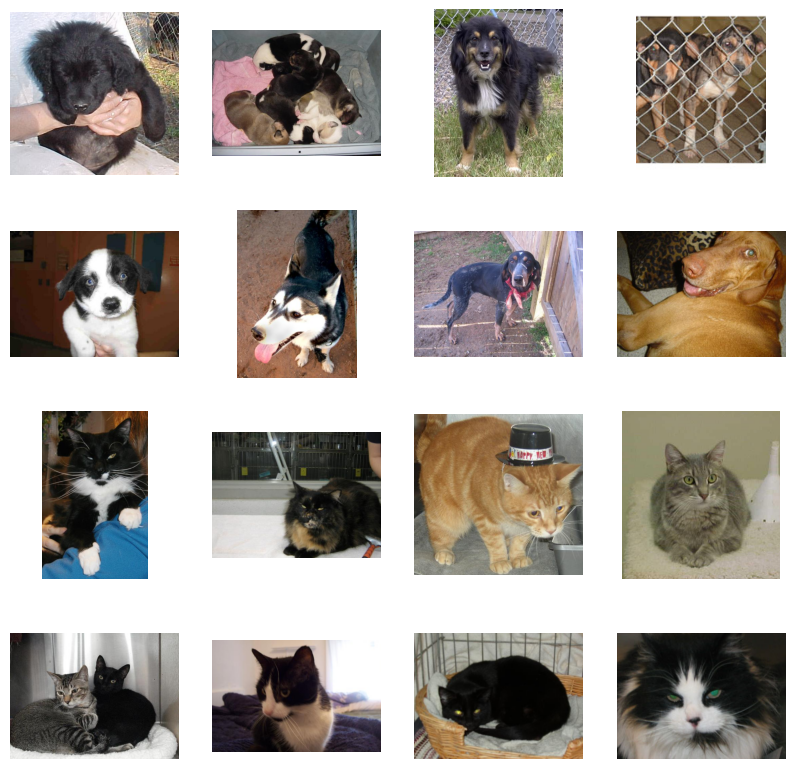

['4458.jpg', '6650.jpg', '5438.jpg', '11677.jpg', '7974.jpg']
['3155.jpg', '8348.jpg', '9131.jpg', '977.jpg', '2960.jpg']
['4458.jpg', '6650.jpg', '5438.jpg', '11677.jpg', '7974.jpg']
['3155.jpg', '8348.jpg', '9131.jpg', '977.jpg', '2960.jpg']


In [ ]:
imgs_dog = os.listdir(DIR_TRAIN_DOG)
test_imgs_dog = os.listdir(DIR_TEST_DOG)
imgs_cat = os.listdir(DIR_TRAIN_DOG)
test_imgs_cat = os.listdir(DIR_TEST_DOG)

samples_dog = [os.path.join(DIR_TRAIN_DOG,np.random.choice(os.listdir(DIR_TRAIN_DOG),1)[0]) for _ in range(8)]
samples_cat = [os.path.join(DIR_TRAIN_CAT,np.random.choice(os.listdir(DIR_TRAIN_CAT),1)[0]) for _ in range(8)]

nrows = 4
ncols = 4

fig, ax = plt.subplots(nrows,ncols,figsize = (10,10))
ax = ax.flatten()

for i in range(nrows*ncols):
  if i < 8:
    pic = plt.imread(samples_dog[i%8])
    ax[i].imshow(pic)
    ax[i].set_axis_off()
  else:
    pic = plt.imread(samples_cat[i%8])
    ax[i].imshow(pic)
    ax[i].set_axis_off()
plt.show()

print(imgs_cat[:5])
print(test_imgs_cat[:5])
print(imgs_dog[:5])
print(test_imgs_dog[:5])

### Data Loader

In [ ]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
    ])
transform_with_erase = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.RandomErasing(),
    ])


trainDataset = torchvision.datasets.ImageFolder(DIR_TRAIN, transform=transform)
trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size = batch_size, shuffle = True, num_workers = 0)
testDataset = torchvision.datasets.ImageFolder(DIR_TEST, transform=transform)
testLoader = torch.utils.data.DataLoader(testDataset, batch_size = batch_size, shuffle = True, num_workers = 0)

trainDataset_erase = torchvision.datasets.ImageFolder(DIR_TRAIN, transform=transform_with_erase)
trainLoader_erase = torch.utils.data.DataLoader(trainDataset_erase, batch_size = batch_size, shuffle = True, num_workers = 0)
testDataset_erase = torchvision.datasets.ImageFolder(DIR_TEST, transform=transform_with_erase)
testLoader_erase = torch.utils.data.DataLoader(testDataset_erase, batch_size = batch_size, shuffle = True, num_workers = 0)

classes = ['Cat', 'Dog']


In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=10).permute(1, 2, 0))
        break

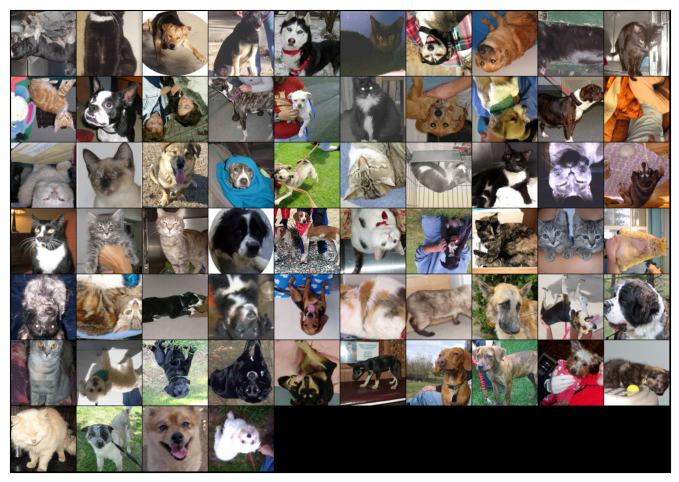

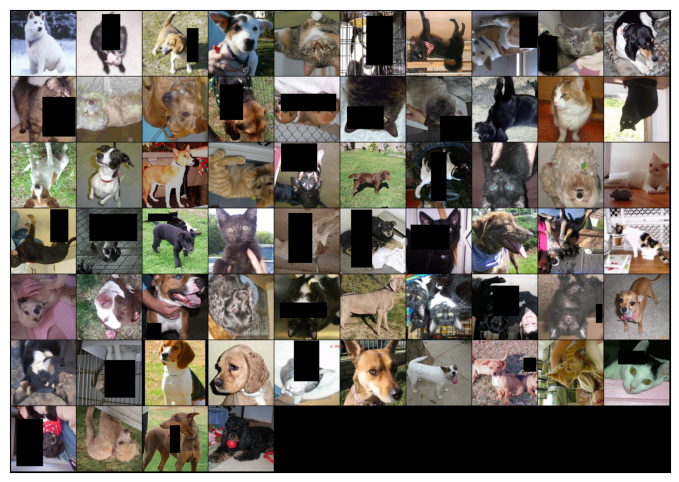

In [ ]:
show_batch(trainLoader)
show_batch(trainLoader_erase)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        images, labels = images.cuda(), labels.cuda()
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        images, labels = images.cuda(), labels.cuda()
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class DogsCatsCnnModelResNet50(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50()
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 2)
        # self.network.fc = nn.Sequential(
        #   nn.Linear(in_features=self.network.fc.in_features, out_features=1),
        # )

    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [ ]:
model_resnet_50 = DogsCatsCnnModelResNet50()

if torch.cuda.is_available():
    model_resnet_50.cuda()

In [ ]:
# Considering for ResNet50
for images, labels in trainLoader:
  images, labels = images.cuda(), labels.cuda()
  print('images.shape:', images.shape)
  out = model_resnet_50(images)
  print('out.shape:', out.shape)
  print('out[0]:', out[0])
  break

images.shape: torch.Size([64, 3, 224, 224])
out.shape: torch.Size([64, 2])
out[0]: tensor([0.3882, 0.4070], device='cuda:0', grad_fn=<SelectBackward0>)


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
trainLoader = DeviceDataLoader(trainLoader, device)
test_Loader = DeviceDataLoader(testLoader, device)
to_device(model_resnet_50, device);

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
print(evaluate(model_resnet_50, testLoader))
print(evaluate(model_resnet_50, testLoader_erase))

{'val_loss': 0.6942969560623169, 'val_acc': 0.31681033968925476}
{'val_loss': 0.6943100094795227, 'val_acc': 0.32866379618644714}


In [ ]:
num_epochs = 40
lr = 0.0001
opt_func = torch.optim.Adam


In [ ]:
history0 = fit(num_epochs, lr, model_resnet_50, trainLoader, testLoader, opt_func)

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch [0], train_loss: 0.6060, val_loss: 0.5815, val_acc: 0.7161
Epoch [1], train_loss: 0.5801, val_loss: 0.6039, val_acc: 0.6773
Epoch [2], train_loss: 0.5603, val_loss: 0.5347, val_acc: 0.7732
Epoch [3], train_loss: 0.5377, val_loss: 0.5525, val_acc: 0.7365
Epoch [4], train_loss: 0.5235, val_loss: 0.6348, val_acc: 0.6568
Epoch [5], train_loss: 0.5051, val_loss: 0.6136, val_acc: 0.6913
Epoch [6], train_loss: 0.4885, val_loss: 0.5098, val_acc: 0.7909
Epoch [7], train_loss: 0.4807, val_loss: 0.5101, val_acc: 0.7980
Epoch [8], train_loss: 0.4770, val_loss: 0.5531, val_acc: 0.7376
Epoch [9], train_loss: 0.4675, val_loss: 0.4790, val_acc: 0.8270
Epoch [10], train_loss: 0.4598, val_loss: 0.5221, val_acc: 0.7764
Epoch [11], train_loss: 0.4537, val_loss: 0.5698, val_acc: 0.7112
Epoch [12], train_loss: 0.4458, val_loss: 0.5018, val_acc: 0.7996
Epoch [13], train_loss: 0.4416, val_loss: 0.4752, val_acc: 0.8276
Epoch [14], train_loss: 0.4352, val_loss: 0.6734, val_acc: 0.6212
Epoch [15], train_lo

In [ ]:
torch.save(model_resnet_50.state_dict(), 'dogscats-cnn-resnet50.pth')
torch.save(model_resnet_50.state_dict(), './content/drive/MyDrive/NCKU_CV_DL/ResNet_20231221.pth',_use_new_zipfile_serialization=False)

In [ ]:
history1 = fit(num_epochs, lr, model_resnet_50, trainLoader_erase, testLoader_erase, opt_func)

Epoch [0], train_loss: 0.4013, val_loss: 0.4351, val_acc: 0.8707
Epoch [1], train_loss: 0.3995, val_loss: 0.4317, val_acc: 0.8750
Epoch [2], train_loss: 0.3963, val_loss: 0.4196, val_acc: 0.8874
Epoch [3], train_loss: 0.3951, val_loss: 0.4156, val_acc: 0.8895


In [ ]:
torch.save(model_resnet_50.state_dict(), 'dogscats-cnn-resnet50-2.pth')
torch.save(model_resnet_50.state_dict(), './content/drive/MyDrive/NCKU_CV_DL/ResNet_20231221_erased.pth',_use_new_zipfile_serialization=False)

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_accuracies(history0)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history0)

In [ ]:
plot_accuracies(history1)

In [ ]:
plot_losses(history1)

In [ ]:
infer_dataset = torchvision.datasets.ImageFolder(DIR_INFER , transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor()]))

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model_resnet_50(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return trainDataset.classes[preds[0].item()]

In [ ]:
model1 = to_device(DogsCatsCnnModelResNet50(), device)

In [ ]:
summary(model1, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
model1.load_state_dict(torch.load('./content/drive/MyDrive/NCKU_CV_DL/ResNet_20231221.pth'))

Predicted: Cat


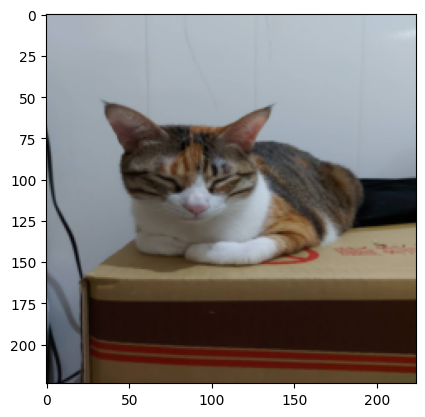

In [ ]:
img, _ = infer_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model1))

In [ ]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    model = model.to("cuda")

In [ ]:
# optimizer = optimizers[op](model.parameters(), lr=learning_rate, momentum=0.9)
# optimizer = optimizers[op](model.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer = optimizers[op](model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
criterion = nn.BCELoss()

summary(model, input_size=(3, 224, 224))

from tqdm import tqdm
from IPython.display import clear_output

train_loss_epochs = []
train_acc_epochs = []
test_loss_epochs = []
test_acc_epochs = []

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
for epoch in range(epochs):
    running_loss = 0.0
    acc_batch = 0.0
    model.train()  # 將model開啟訓練模式

    for i, data in tqdm(enumerate(trainLoader, 1)):
        inputs, labels = data

        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
            labels = torch.unsqueeze(labels, 1)

        inputs = Variable(inputs)
        labels = Variable(labels)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels.to(torch.float))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        acc_batch += (predicted == labels).sum().item()


    running_loss /= i
    acc_batch /= (i * batch_size)


    print("[%2d, %5d] Train Loss: %.3f" % (epoch + 1, i * batch_size, running_loss))
    print("[%2d, %5d] Train Accuracy: %.3f" % (epoch + 1, i * batch_size, acc_batch))

    train_loss_epochs.append(running_loss)
    train_acc_epochs.append(acc_batch)

    model.eval()  # 將model開啟驗證模式
    running_loss = 0.0    # 歸零給test使用
    acc_batch = 0.0     # 歸零給test使用

    with torch.no_grad():
      for i, data in enumerate(testLoader, 1):
          inputs, labels = data
          if use_gpu:
              inputs = inputs.cuda()
              labels = labels.cuda()
              labels = torch.unsqueeze(labels, 1)

          inputs = Variable(inputs, volatile=True)
          labels = Variable(labels, volatile=True)

          outputs = model(inputs)
          loss = criterion(outputs, labels.to(torch.float))
          _, predicted = torch.max(outputs.data, 1)
          num_correct = (predicted == labels).sum().item()

          running_loss += loss.item()
          acc_batch += num_correct

      running_loss /= i
      acc_batch /= (i * batch_size)
      test_loss_epochs.append(running_loss)
      test_acc_epochs.append(acc_batch)

    print("[%2d, %5d] Test Loss: %.3f" % (epoch + 1, i * batch_size, running_loss))
    print("[%2d, %5d] Test Accuracy: %.3f" % (epoch + 1, i * batch_size, acc_batch))

print(train_loss_epochs)
print(train_acc_epochs)
print(test_loss_epochs)
print(test_acc_epochs)

torch.save(model, './content/drive/MyDrive/NCKU_CV_DL/ResNet_20231220.pth',_use_new_zipfile_serialization=False)


123it [03:46,  1.92s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
127it [03:52,  1.83s/it]


[ 1, 16256] Train Loss: 0.427
[ 1, 16256] Train Accuracy: 42.528


<ipython-input-16-3169fa51bfb8>:58: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs = Variable(inputs, volatile=True)
<ipython-input-16-3169fa51bfb8>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  labels = Variable(labels, volatile=True)


KeyboardInterrupt: ignored

In [ ]:
# 畫圖
plt.plot(train_loss_epochs, label='train_loss')
plt.plot(test_loss_epochs, label='val_loss')
plt.title("Loss")  # 設定圖標題及其文字大小
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.savefig('./content/drive/MyDrive/NCKU_CV_DL/ResNet_loss.png')
plt.legend()
plt.show()

plt.plot(train_acc_epochs, label='train_acc')
plt.plot(test_acc_epochs, label='val_acc')
plt.title("acc")  # 設定圖標題及其文字大小
plt.xlabel('epoch')
plt.ylabel('acc value')
plt.savefig('./content/drive/MyDrive/NCKU_CV_DL/ResNet_accuracy.png')
plt.legend()
plt.show()
